# Google Earth Engine

Structure:
- Set virtual environment
- Install GEE Python API
- Initialize and authenticate GEE Project
- Data import and visualization
    - Basic map
    - Country map
    - Maps by year
- Convert to dataframe
    - Trends over time
- Examples
    - Night Time Lights
    - Land Cover

----------------------------

#### 0) Set Virtual Environment

In [18]:
#pip install virtualenv
#pip freeze > requirements.txt

Open terminal and run: _python -m venv .venv_

MacOS/Linux Users:
- run source .venv/bin/activate

Windows Users:
- run .\venv\Scripts\activate

#### 1) Install GEE Python API

In [19]:
pip install geemap

Note: you may need to restart the kernel to use updated packages.


#### 2) Initialize and authenticate Google Earth Engine Project 

_ee.Authenticate_ will open a browser window where a new project can be created on GEE. Copy the 'key' and enter in the box here as prompted to connect.

In [20]:
import geemap, ee
import ipyleaflet 
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

In [21]:
ee.Authenticate()

True

Initialize the project using ee.Initialize(). Additionally, you may also enter the name of your GEE project: _ee.Initialize(project = 'your project')_

In [22]:
ee.Initialize()

#### 3) Import data from GEE

3.1) Select data source

Data catalog: https://developers.google.com/earth-engine/datasets

Enter the Image Collection ID in _ee.ImageCollection_

In [23]:
data = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG")

Set parameters:

In [24]:
latitude = 0.02
longitude = 37.9
zoom = 6
start_date = '2024-01-01'
end_date = '2024-05-01'
band = 'avg_rad'

3.2) Generate a basic map

In [25]:
def gen_map(start, end, data, band, layername):
    """
    This function plots 1) basemap and 2) data from GEE. 
    First, the data source is filtered for the band (or variable) and date range.
    Second, the basemap is plotted and layered with GEE data.
    """
    source_filtered = data.select(band).filter(ee.Filter.date(start, end))

    source_filtered_map = geemap.Map()
    source_filtered_map.addLayer(source_filtered, {'min': 0, 'max': 10, 'palette': ['black', 'white']}, name = f'{layername} [{start} to {end}', opacity = 0.8)
    source_filtered_map.addLayerControl()
    
    return source_filtered_map

In [26]:
gen_map(start_date, end_date, data, 'avg_rad', 'VIIRS')

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

3.3) Generate country map

In [27]:
def gen_map_poi_country(latitude, longitude, zoom, start, end, data, band, countryname, layername):
    """
    This function plots 1) basemap and 2) data from GEE for the country of interest.
    First, the data is filtered for the band (or variable) and date range.
    Second, country boundary is fetched from GEE and data is clipped to the country boundary.
    Third, basemap is plotted centered on the latitude/longitude provided.
    Fourth, basemap is layered with GEE data.
    """
    
    source_filtered = data.select(band).filter(ee.Filter.date(start, end))

    poi = ee.FeatureCollection('USDOS/LSIB/2017').filter(ee.Filter.eq('COUNTRY_NA',countryname))
    source_filtered_clip = source_filtered.median().clipToCollection(poi)
    
    source_filtered_map = geemap.Map(center = [latitude, longitude], zoom = zoom)

    source_filtered_map.addLayer(source_filtered_clip, {'min': 0, 'max': 10, 'palette': ['black', 'white']}, name = f'{layername} [{start} to {end}', opacity = 0.8)
    source_filtered_map.addLayerControl()
    
    return source_filtered_map

In [28]:
gen_map_poi_country(latitude, longitude, zoom, start_date, end_date, data, band, 'Kenya', 'VIIRS Kenya')

Map(center=[0.02, 37.9], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(…

3.4) Generate country map for multiple years

In [29]:
def gen_map_poi_yearly(latitude, longitude, zoom, year1, year2, data, band, countryname, layername):
    """
    This function plots 1) basemap and 2) data from GEE for the country of interest for multiple years.
    First, the data is filtered for the band (or variable) and years.
    Second, country boundary is fetched from GEE and the filtered datasets are clipped to the country boundary.
    Third, basemap is plotted centered on the latitude/longitude provided.
    Fourth, basemap is layered with GEE data.
    """    
    source_filtered1 = data.select(band).filter(ee.Filter.calendarRange(year1, year1, 'year'))
    source_filtered2 = data.select(band).filter(ee.Filter.calendarRange(year2, year2, 'year'))

    poi = ee.FeatureCollection('USDOS/LSIB/2017').filter(ee.Filter.eq('COUNTRY_NA',countryname))
    source_filtered_clip1 = source_filtered1.median().clipToCollection(poi)
    source_filtered_clip2 = source_filtered2.median().clipToCollection(poi)
    
    source_filtered_map = geemap.Map(center = [latitude, longitude], zoom = zoom)

    source_filtered_map.addLayer(source_filtered_clip1, {'min': 0, 'max': 10, 'palette': ['black', 'white']}, name = f'{layername} [{year1}]', opacity = 0.8)
    source_filtered_map.addLayer(source_filtered_clip2, {'min': 0, 'max': 10, 'palette': ['black', 'white']}, name = f'{layername} [{year2}]', opacity = 0.8)
    
    source_filtered_map.addLayerControl()
    
    return source_filtered_map

In [30]:
gen_map_poi_yearly(latitude, longitude, zoom, 2014, 2024, data, band, 'Kenya', 'VIIRS Kenya')

Map(center=[0.02, 37.9], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(…

#### 4) Convert to dataframe

In [31]:
#ee.Date(data.first().get('system:time_start')).format("yyyy-MM-dd")

In [32]:
poi = ee.Geometry.Point(longitude, latitude)
scale = 500
viirs_poi = data.getRegion(poi, scale).getInfo()

df_columns = pd.DataFrame(viirs_poi).iloc[0]
df_data = pd.DataFrame(viirs_poi).values[1:]
df = pd.DataFrame(df_data, columns = df_columns)
df['datetime'] = pd.to_datetime(df['time'], unit='ms') #default time is in epoch which is milliseconds since 1970-01-01
df


,id,longitude,latitude,time,avg_rad,cf_cvg,datetime
0,20140101,37.902168,0.020212,1388534400000,0.025511,15,2014-01-01
1,20140201,37.902168,0.020212,1391212800000,0.08641,12,2014-02-01
2,20140301,37.902168,0.020212,1393632000000,0.327529,11,2014-03-01
3,20140401,37.902168,0.020212,1396310400000,0.263549,7,2014-04-01
4,20140501,37.902168,0.020212,1398902400000,0.031875,7,2014-05-01
...,...,...,...,...,...,...,...
121,20240201,37.902168,0.020212,1706745600000,0.51,12,2024-02-01
122,20240301,37.902168,0.020212,1709251200000,0.37,10,2024-03-01
123,20240401,37.902168,0.020212,1711929600000,0,0,2024-04-01
124,20240501,37.902168,0.020212,1714521600000,0.35,3,2024-05-01


4.1) Plot trends over time

Text(0, 0.5, 'Date')

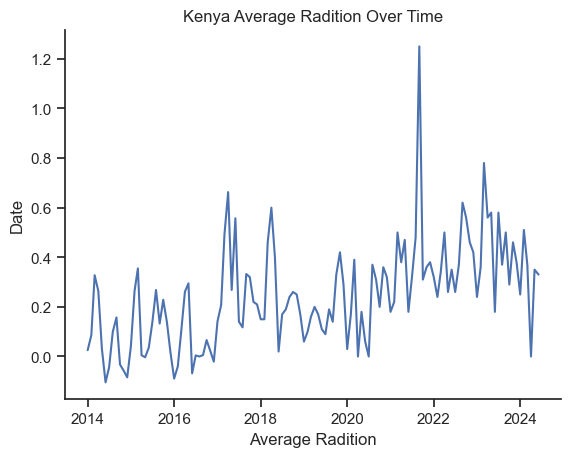

In [33]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
sns.lineplot(x = 'datetime', y = 'avg_rad', data = df).set_title("Kenya Average Radition Over Time")
plt.xlabel("Average Radition")
plt.ylabel("Date")